In [0]:
# loading all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics, cross_validation
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
from keras import optimizers
from keras import regularizers
from keras.constraints import maxnorm
from keras.layers import Dropout, BatchNormalization
from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [0]:
from google.colab import drive

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
BackOrders = pd.read_csv("/content/drive/My Drive/Colab_Folder/BackOrders.csv", na_values=["?",","])
BackOrders.head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


In [40]:
BackOrders.describe() # missing values in lead_time

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,6.158900e+04,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,4.196427e+02,43.087256,1.605400,-6.264182,-5.863664,1.205361
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,1.269858e+04,959.614135,42.309229,25.537906,24.844514,29.981155
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-99.000000,-99.000000,0.000000
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.620000,0.640000,0.000000
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,6.000000e+00,0.000000,0.000000,0.820000,0.800000,0.000000
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,5.100000e+01,3.000000,0.000000,0.960000,0.950000,0.000000
max,3.284895e+06,673445.000000,52.000000,170976.000000,1.126656e+06,2.094336e+06,3.062016e+06,295197.000000,934593.000000,1.799099e+06,2.631590e+06,192978.000000,7392.000000,1.000000,1.000000,2999.000000


Exploratory analysis to impute lead time

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


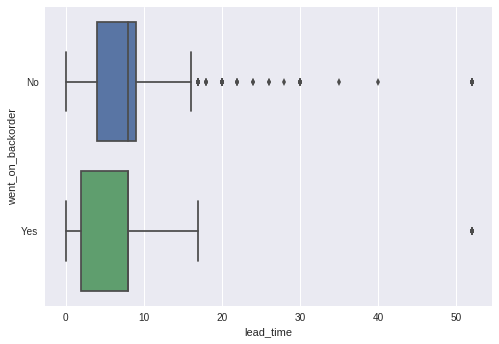

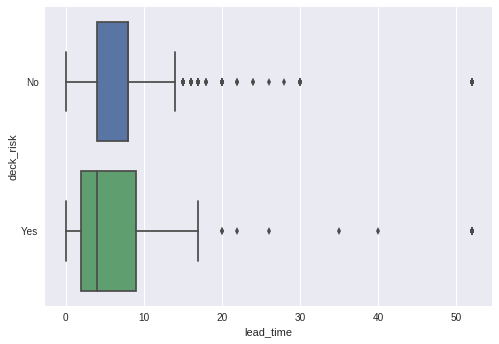

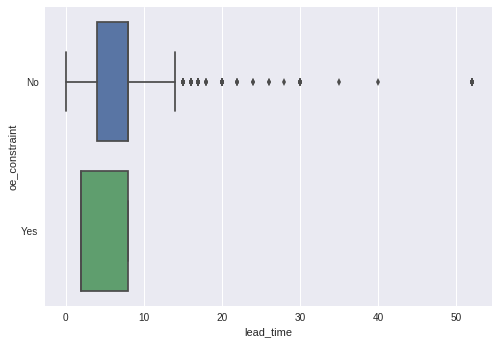

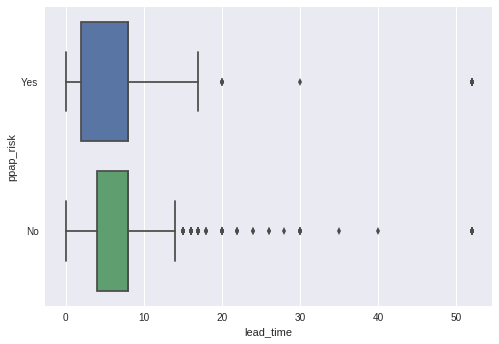

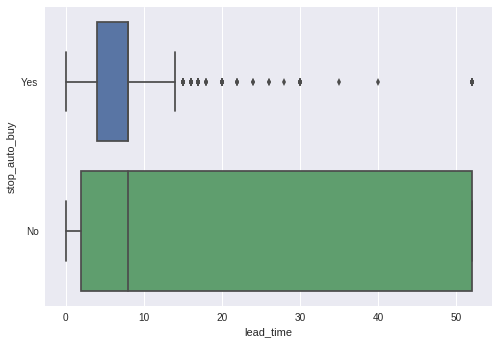

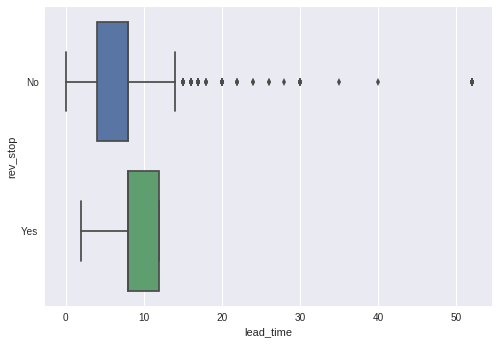

In [11]:
columns = ["went_on_backorder", "deck_risk", "oe_constraint", "ppap_risk", "stop_auto_buy", "rev_stop"]

for col in columns:
  plt.figure()
  sns.boxplot(x="lead_time", y=col, data=BackOrders)



Evaluating fields hich can be used to impute lead time NA values

In [0]:
print(BackOrders.groupby('stop_auto_buy', as_index=False)['lead_time'].mean())
print(BackOrders.groupby('rev_stop', as_index=False)['lead_time'].mean())
print(BackOrders.groupby('oe_constraint', as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'oe_constraint'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'rev_stop'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['rev_stop', 'oe_constraint'], as_index=False)['lead_time'].mean())
print(BackOrders.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'], as_index=False)['lead_time'].mean())

Imputing lead_time

In [0]:

BackOrders['lead_time'] = BackOrders.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'])['lead_time'].transform(lambda x: x.fillna(x.mean()))


Changing datatype of objects column to categories for dummification later on

In [0]:

def dtype_Convert(dtp1, col, data):
    for i in range(len(dtp1)):
        if dtp1[i] == "object":
            data[col[i]]=data[col[i]].astype('category')

In [0]:
dtp = pd.Series(BackOrders.dtypes)
dtp1 = dtp.tolist()
col = BackOrders.columns.tolist()

In [0]:
dtype_Convert(dtp1, col, BackOrders)

Outlier detection and treatment

In [0]:
cols = list(BackOrders.select_dtypes(include=['int', 'float']).columns)

for col in cols:
  plt.figure()
  sns.boxplot(x=col, y="went_on_backorder", data=BackOrders)

In [0]:
cols = list(BackOrders.select_dtypes(include=['int', 'float']).columns)

cols = [e for e in cols if e not in ("local_bo_qty", "lead_time", "sku")]


Using quantile methods for outier treatment.
Outlier treatment on new data to compare with old dataset

In [0]:
BackOrders_NoOut = pd.read_csv("/content/drive/My Drive/Colab_Folder/BackOrders.csv", na_values=["?",","])
BackOrders_NoOut['lead_time'] = BackOrders_NoOut.groupby(['stop_auto_buy', 'rev_stop', 'oe_constraint'])['lead_time'].transform(lambda x: x.fillna(x.mean()))

In [0]:
def outliers_iqr(cols, df):
  for col in cols:
    quartile_1 = df[col].quantile(0.25) 
    quartile_3 = df[col].quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    median = df[col].median()
    df[col] = df[col].mask(df[col] > upper_bound, median)
    df[col] = df[col].mask(df[col] < lower_bound, median)   
  return

In [0]:
outliers_iqr(cols, BackOrders_NoOut)

Comparing summary to check effect of outlier treatment

In [49]:

print(pd.concat([pd.DataFrame(BackOrders.describe()), pd.DataFrame(BackOrders_NoOut.describe())]))

                sku   national_inv     lead_time  in_transit_qty  \
count  6.158900e+04   61589.000000  61589.000000    61589.000000   
mean   2.037188e+06     287.721882      7.679858       30.192843   
std    6.564178e+05    4233.906931      6.414996      792.869253   
min    1.068628e+06   -2999.000000      0.000000        0.000000   
25%    1.498574e+06       3.000000      4.000000        0.000000   
50%    1.898033e+06      10.000000      8.000000        0.000000   
75%    2.314826e+06      57.000000      8.000000        0.000000   
max    3.284895e+06  673445.000000     52.000000   170976.000000   
count  6.158900e+04   61589.000000  61589.000000    61589.000000   
mean   2.037188e+06      18.053646      7.679858        0.000000   
std    6.564178e+05      27.157908      6.414996        0.000000   
min    1.068628e+06     -75.000000      0.000000        0.000000   
25%    1.498574e+06       3.000000      4.000000        0.000000   
50%    1.898033e+06      10.000000      8.000000

In [0]:
mapping_dictionary = {"went_on_backorder":{ "Yes": 1, "No": 0}}
BackOrders_NoOut1 = BackOrders_NoOut.replace(mapping_dictionary)

0    50296
1    11293
Name: went_on_backorder, dtype: int64


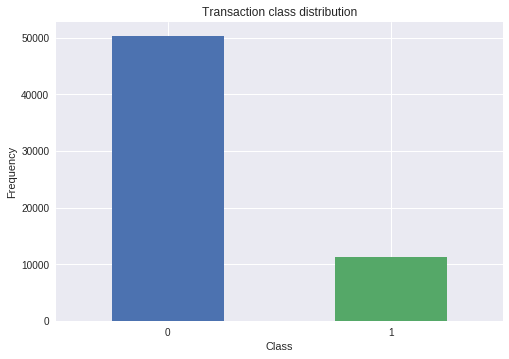

In [51]:
#Plotting the frequencies of orders which went into backorder and which did not
count_classes = pd.value_counts(BackOrders_NoOut1['went_on_backorder'], sort = True)
print(count_classes)

#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0)

#Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [21]:
print(BackOrders_NoOut1.shape)
print(BackOrders_NoOut.shape)

(61589, 23)
(61589, 23)


In [0]:
BackOrders_NoOut2 = pd.get_dummies(BackOrders_NoOut1)

In [53]:
BackOrders_NoOut2.describe(include = 'all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,deck_risk_No,deck_risk_Yes,oe_constraint_No,oe_constraint_Yes,ppap_risk_No,ppap_risk_Yes,stop_auto_buy_No,stop_auto_buy_Yes,rev_stop_No,rev_stop_Yes
count,6.158900e+04,61589.000000,61589.000000,61589.0,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,...,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000,61589.000000
mean,2.037188e+06,18.053646,7.679858,0.0,2.320950,4.951923,7.165874,1.457013,4.641300,9.253958,...,0.781714,0.218286,0.999805,0.000195,0.873403,0.126597,0.037117,0.962883,0.999675,0.000325
std,6.564178e+05,27.157908,6.414996,0.0,5.767793,11.631048,16.642746,2.981867,8.218458,16.263241,...,0.413086,0.413086,0.013957,0.013957,0.332524,0.332524,0.189050,0.189050,0.018018,0.018018
min,1.068628e+06,-75.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.498574e+06,3.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.898033e+06,10.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,2.314826e+06,18.000000,8.000000,0.0,0.000000,2.000000,4.000000,1.000000,4.000000,9.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,3.284895e+06,138.000000,52.000000,0.0,30.000000,62.000000,90.000000,15.000000,42.000000,85.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
BackOrders_NoOut2.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'went_on_backorder', 'potential_issue_No',
       'potential_issue_Yes', 'deck_risk_No', 'deck_risk_Yes',
       'oe_constraint_No', 'oe_constraint_Yes', 'ppap_risk_No',
       'ppap_risk_Yes', 'stop_auto_buy_No', 'stop_auto_buy_Yes', 'rev_stop_No',
       'rev_stop_Yes'],
      dtype='object')

Creating training and test set




In [0]:
# Divide in to train and test
y=BackOrders_NoOut2["went_on_backorder"]
X=BackOrders_NoOut2.drop('went_on_backorder', axis=1)

#from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(49271, 28)
(12318, 28)
(49271,)
(12318,)


In [0]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [59]:
input_dim = X_train.shape[1]
print(input_dim)
# encoding_dim = 15

28


In [0]:
model = Sequential()
model.add(Dense(1,input_dim=input_dim, activation='sigmoid', kernel_initializer='random_normal',kernel_regularizer="l1"))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [52]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
49271/49271 [==============================] - 9s 190us/step - loss: 0.4993 - acc: 0.8101
Epoch 2/50
49271/49271 [==============================] - 6s 126us/step - loss: 0.4161 - acc: 0.8302
Epoch 3/50
49271/49271 [==============================] - 5s 109us/step - loss: 0.4051 - acc: 0.8328
Epoch 4/50
49271/49271 [==============================] - 5s 106us/step - loss: 0.4015 - acc: 0.8344
Epoch 5/50
49271/49271 [==============================] - 5s 103us/step - loss: 0.4000 - acc: 0.8361
Epoch 6/50
49271/49271 [==============================] - 6s 127us/step - loss: 0.3990 - acc: 0.8370
Epoch 7/50
49271/49271 [==============================] - 7s 149us/step - loss: 0.3986 - acc: 0.8383
Epoch 8/50
49271/49271 [==============================] - 8s 153us/step - loss: 0.3983 - acc: 0.8387
Epoch 9/50
49271/49271 [==============================] - 8s 156us/step - loss: 0.3981 - acc: 0.8395
Epoch 10/50
49271/49271 [==============================] - 6s 128us/step - loss: 0.3979 - a

In [53]:
scores = model.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

49271/49271 [==============================] - 4s 73us/step
acc: 84.15%


In [0]:
y_pred_class = model.predict_classes(X_test)

In [55]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8420198084104562

In [0]:
# print the confusion matrix
confusion_matrix_test=metrics.confusion_matrix(y_test, y_pred_class)

In [57]:
confusion_matrix_test

array([[9852,  197],
       [1749,  520]])

In [58]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.980396059309384
Test TPR:  0.22917584839136185
Test Accuracy:  0.8420198084104562


In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(4,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l1"))
model_MLP.add(Dense(1,activation='sigmoid'))
model_MLP.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(14,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l1"))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
model_MLP.add(BatchNormalization())
model_MLP.add(Dense(1,activation='sigmoid'))
model_MLP.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(14,input_dim=input_dim, activation='tanh', kernel_initializer='random_normal',kernel_regularizer="l2"))
# model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
# model_MLP.add(BatchNormalization())
model_MLP.add(Dense(1,activation='sigmoid'))


In [0]:
model_MLP.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [53]:
model_MLP.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
49271/49271 [==============================] - 10s 206us/step - loss: 0.4005 - acc: 0.8511
Epoch 2/50
49271/49271 [==============================] - 10s 198us/step - loss: 0.3557 - acc: 0.8689
Epoch 3/50
49271/49271 [==============================] - 10s 195us/step - loss: 0.3450 - acc: 0.8744
Epoch 4/50
49271/49271 [==============================] - 10s 202us/step - loss: 0.3390 - acc: 0.8792
Epoch 5/50
49271/49271 [==============================] - 10s 205us/step - loss: 0.3336 - acc: 0.8807
Epoch 6/50
49271/49271 [==============================] - 10s 195us/step - loss: 0.3296 - acc: 0.8837
Epoch 7/50
49271/49271 [==============================] - 10s 195us/step - loss: 0.3263 - acc: 0.8832
Epoch 8/50
49271/49271 [==============================] - 10s 198us/step - loss: 0.3245 - acc: 0.8844
Epoch 9/50
49271/49271 [==============================] - 10s 196us/step - loss: 0.3216 - acc: 0.8850
Epoch 10/50
49271/49271 [==============================] - 10s 196us/step - loss: 

In [56]:
lr_values = np.logspace(-4, -1, num=5)
lr_values

array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ])

In [0]:
lr_values = [0.003]

In [66]:
nb_epoch = 20
batch_size = 32

def compile_fit(model, X, Y, lr_value):
    
    adam = optimizers.Adam(lr=lr_value)
    
    model_MLP.compile(optimizer=adam, 
                    loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model_MLP.fit(X, Y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)    
    return history
  
hist = []
training_loss = []
val_loss = []


for lr_value in lr_values:
    print(lr_value)
    history = (compile_fit(model_MLP, X_train, y_train, lr_value))
  
    hist.append(history)
  
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
  

0.003
Train on 34489 samples, validate on 14782 samples
Epoch 1/20
34489/34489 [==============================] - 9s 251us/step - loss: 0.3592 - acc: 0.8559 - val_loss: 0.3445 - val_acc: 0.8499
Epoch 2/20
34489/34489 [==============================] - 8s 224us/step - loss: 0.3257 - acc: 0.8726 - val_loss: 0.3155 - val_acc: 0.8775
Epoch 3/20
34489/34489 [==============================] - 8s 227us/step - loss: 0.3171 - acc: 0.8766 - val_loss: 0.3127 - val_acc: 0.8767
Epoch 4/20
34489/34489 [==============================] - 8s 230us/step - loss: 0.3126 - acc: 0.8804 - val_loss: 0.3076 - val_acc: 0.8809
Epoch 5/20
34489/34489 [==============================] - 8s 229us/step - loss: 0.3099 - acc: 0.8807 - val_loss: 0.3074 - val_acc: 0.8791
Epoch 6/20
34489/34489 [==============================] - 8s 222us/step - loss: 0.3081 - acc: 0.8819 - val_loss: 0.3136 - val_acc: 0.8771
Epoch 7/20
34489/34489 [==============================] - 8s 222us/step - loss: 0.3090 - acc: 0.8828 - val_loss: 0.2

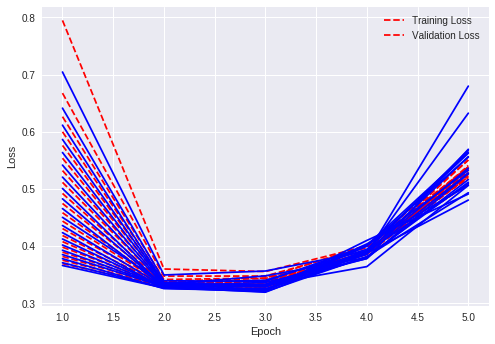

In [58]:
# Create count of the number of epochs
epoch_count = range(1, len(nb_epoch))

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [45]:
scores = model_MLP.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model_MLP.metrics_names[1], scores[1]*100))

49271/49271 [==============================] - 3s 67us/step
acc: 89.10%


In [0]:
y_pred_class_MLP = model_MLP.predict_classes(X_test)

In [47]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred_class_MLP)

0.885046273745738

In [0]:
# print the confusion matrix
confusion_matrix_test_mlp=metrics.confusion_matrix(y_test,y_pred_class_MLP)

In [49]:
Accuracy_Test=(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[1,1])/(confusion_matrix_test_mlp[0,0]+confusion_matrix_test_mlp[0,1]+confusion_matrix_test_mlp[1,0]+confusion_matrix_test_mlp[1,1])
TNR_Test= confusion_matrix_test_mlp[0,0]/(confusion_matrix_test_mlp[0,0] +confusion_matrix_test_mlp[0,1])
TPR_Test= confusion_matrix_test_mlp[1,1]/(confusion_matrix_test_mlp[1,0] +confusion_matrix_test_mlp[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9581594116477837
Test TPR:  0.5589539007092199
Test Accuracy:  0.885046273745738


using grid search approach to find the best model

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [0]:
def create_model(init_mode, activation, kernel_regularizer, neurons, learn_rate):
    
#     # create model
#     model = Sequential()
#     model.add(Dense(4, input_dim=15, kernel_initializer=init_mode, activation='tanh'))
#     model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    
#     # Compile model
#     sgd=optimizers.SGD(0.001)
#     model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # create model
    adam = optimizers.Adam(lr=learn_rate)
    
    
    model_MLP = Sequential()
    model_MLP.add(Dense(neurons,input_dim=input_dim, activation=activation, kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    model_MLP.add(Dense(4, activation='relu', kernel_constraint=maxnorm(3)))
    model_MLP.add(Dense(1,activation='sigmoid'))
    
    # compile model
    model_MLP.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model_MLP


In [0]:
model = KerasClassifier(build_fn=create_model, epochs=25, verbose=1)

In [63]:
init_mode = ['uniform', 'lecun_uniform']
kernel_regularizer = ['l1', 'l2']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
batch_size = [32, 64]
learn_rate = [0.003, 0.006]
# epochs=[20,30]
neurons = [10, 14, 20]
# batch_size=[32]
param_grid = dict(init_mode=init_mode,
                  kernel_regularizer = kernel_regularizer, 
                  batch_size=batch_size,
                  activation = activation, 
                  learn_rate = learn_rate, neurons=neurons
                 )
param_grid

{'activation': ['softmax',
  'softplus',
  'softsign',
  'relu',
  'tanh',
  'sigmoid',
  'linear'],
 'batch_size': [32, 64],
 'init_mode': ['uniform', 'lecun_uniform'],
 'kernel_regularizer': ['l1', 'l2'],
 'learn_rate': [0.003, 0.006],
 'neurons': [10, 14, 20]}

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='f1')
grid_result = grid.fit(X_train, y_train)

Epoch 1/25
32847/32847 [==============================] - 10s 302us/step - loss: 0.4531 - acc: 0.8196
Epoch 2/25
32847/32847 [==============================] - 7s 220us/step - loss: 0.3637 - acc: 0.8571
Epoch 3/25
32847/32847 [==============================] - 7s 221us/step - loss: 0.3523 - acc: 0.8672
Epoch 4/25
32847/32847 [==============================] - 7s 222us/step - loss: 0.3496 - acc: 0.8704
Epoch 5/25
32847/32847 [==============================] - 7s 216us/step - loss: 0.3487 - acc: 0.8727
Epoch 6/25
32847/32847 [==============================] - 7s 218us/step - loss: 0.3487 - acc: 0.8730
Epoch 7/25
32847/32847 [==============================] - 7s 221us/step - loss: 0.3479 - acc: 0.8733
Epoch 8/25
32847/32847 [==============================] - 7s 219us/step - loss: 0.3469 - acc: 0.8733
Epoch 9/25
32847/32847 [==============================] - 7s 220us/step - loss: 0.3483 - acc: 0.8736
Epoch 10/25
32847/32847 [==============================] - 7s 218us/step - loss: 0.3469 - 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


32847/32847 [==============================] - 2s 52us/step
Epoch 1/25
32848/32848 [==============================] - 10s 298us/step - loss: 0.4651 - acc: 0.8186
Epoch 2/25
32848/32848 [==============================] - 7s 217us/step - loss: 0.3880 - acc: 0.8386
Epoch 3/25
32848/32848 [==============================] - 7s 216us/step - loss: 0.3769 - acc: 0.8514
Epoch 4/25
32848/32848 [==============================] - 7s 219us/step - loss: 0.3721 - acc: 0.8551
Epoch 5/25
32848/32848 [==============================] - 7s 216us/step - loss: 0.3684 - acc: 0.8581
Epoch 6/25
32848/32848 [==============================] - 7s 216us/step - loss: 0.3662 - acc: 0.8616
Epoch 7/25
32848/32848 [==============================] - 7s 219us/step - loss: 0.3654 - acc: 0.8618
Epoch 8/25
32848/32848 [==============================] - 7s 217us/step - loss: 0.3641 - acc: 0.8625
Epoch 9/25
32848/32848 [==============================] - 7s 218us/step - loss: 0.3633 - acc: 0.8648
Epoch 10/25
32848/32848 [=====

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Part from assignment 2

In [0]:
train, test = train_test_split(BackOrders_Out, test_size=0.2, random_state=12345)
print(train.shape)
print(test.shape)

In [0]:
# removing sku column
# train = train.iloc[:, :-"sku"]
train = train.drop("sku", axis=1)
# train.head(5)
test = test.drop("sku", axis=1)
# train.head(5)

Let us consider  went_on_backorder =  'yes' as rare class and separate the two classes to fit an autoencoder

In [0]:
#Now consider only the non-fraud records for training
train_No = train.loc[train["went_on_backorder"] == "No"]
print(train_No.shape)

# #Now consider only the non-fraud records for training
train_Yes = train.loc[train["went_on_backorder"] == "Yes"]
# train_Yes = train_Yes[:,"went_on_backorder"]
print(train_Yes.shape)

In [0]:
X_train_No = train_No.iloc[:, :-1] #removing target column
print(X_train_No.shape)

Clubbing test data with went_on_backorder =  'yes' of train data to ensure that the model is only trained on went_on_backorder =  'no'

In [0]:
test1 = pd.concat([train_Yes, test])
print(test1.shape)

In [0]:
X_test,X_eval = train_test_split(test1, test_size=0.2, random_state=1111)

In [0]:
#Separating the independent and the class variable
y_test = X_test.iloc[:,-1]
X_test = X_test.iloc[:, :-1]

Converting "category" columns to dummy variables

In [0]:
X_train_No = pd.get_dummies(X_train_No)
X_test = pd.get_dummies(X_test)

Scaling the datasets

In [0]:
x = X_train_No.values #returns a numpy array
min_max_scaler_train = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_train.fit_transform(x)
X_train_No_scaled = pd.DataFrame(x_scaled, columns=X_train_No.columns)


In [0]:
x = X_test.values #returns a numpy array
min_max_scaler_test = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_test.fit_transform(x)
X_test_scaled = pd.DataFrame(x_scaled, columns=X_test.columns)

Training Autoencoders

In [0]:
input_dim = X_train_No_scaled.shape[1]
encoding_dim = 15


Simple autoencoder: similar to "Fraud Detection Exercise"

In [0]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='linear'))

In [0]:
nb_epoch = 40
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

In [0]:
hist = []
training_loss = []
val_loss = []

for _ in range(nb_epoch):
    history = autoencoder.fit(X_train_No_scaled, X_train_No_scaled,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)
#     print(type(history.history['loss']))
    
    hist.append(history)
    
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Fitting slightly complex autoencoder architecture

In [0]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(int(encoding_dim / 2), activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='linear'))

In [0]:
nb_epoch = 15
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

In [0]:
hist = []
training_loss = []
val_loss = []

for _ in range(nb_epoch):
    history = autoencoder.fit(X_train_No_scaled, X_train_No_scaled,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)
#     print(type(history.history['loss']))
    
    hist.append(history)
    
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Testing is the trained autoencoder is able to differentiate between classes

In [0]:
x_tr_inv = min_max_scaler_train.inverse_transform(X_train_No_scaled)
X_train_No_Unscaled = pd.DataFrame(x_tr_inv, columns=X_train_No_scaled.columns)
x_test_inv = min_max_scaler_test.inverse_transform(X_test_scaled)
X_test_Unscaled = pd.DataFrame(x_test_inv, columns=X_test_scaled.columns)

In [0]:
y_test1 = pd.DataFrame(y_test)

df1= X_test_Unscaled
y_test1 = y_test1.set_index(df1.index)
df1['went_on_backorder'] = y_test1.iloc[:,0].values


test_yes=df1.loc[df1["went_on_backorder"] == "Yes"]
print(test_yes.shape)

test_no=df1.loc[df1["went_on_backorder"] == "No"]
print(test_no.shape)

In [0]:
#Getting the errors from the went_on_order = 'no' data separately 
autoencoder.evaluate(test_no.iloc[:,:-1],test_no.iloc[:,:-1])

In [0]:
#Getting the errors from the non fraud data separately 
autoencoder.evaluate(test_yes.iloc[:,:-1],test_yes.iloc[:,:-1])

In [0]:
#Obtaining predictions for non fraud records
predictions_no=autoencoder.predict(test_no.iloc[:,:-1])
predictions_yes=autoencoder.predict(test_yes.iloc[:,:-1])                                              

In [0]:
#Computing errors on the non-fraud data
errors_no = np.mean(np.square(np.abs(test_no.iloc[:,:-1]-predictions_no)), axis=1)
errors_no[0:5]

In [0]:
#Computing errors on the non-fraud data
errors_yes = np.mean(np.square(np.abs(test_yes.iloc[:,:-1]-predictions_yes)), axis=1)
errors_yes[0:5]

In [0]:
#Computing the distribution of errors in both non-fraud and fraud data
print(np.min(errors_no))
print(np.max(errors_no))
print(np.median(errors_no))

print(np.min(errors_yes))
print(np.max(errors_yes))
print(np.median(errors_yes))

In [0]:
#PLotting the error box plots 
plt.subplot(1, 2, 1)
sns.boxplot(y=errors_yes)


plt.subplot(1, 2, 2)
sns.boxplot(y=errors_no)

In [0]:
print(errors_yes.quantile(np.linspace(.1, 1, 9, 0)))
print(errors_no.quantile(np.linspace(.1, 1, 9, 0)))

Implementing autoencoders with hyperparameters Dropout with Maxnorm Constraints and Batch
Normalization

In [0]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5)))
# autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(int(encoding_dim / 2), activation='relu', kernel_constraint=maxnorm(3)))
autoencoder.add(BatchNormalization())
# autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(encoding_dim, activation='tanh'))
# autoencoder.add(BatchNormalization())
autoencoder.add(Dense(input_dim, activation='linear'))

In [0]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='relu', kernel_constraint=maxnorm(3)))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(int(encoding_dim / 2), activation='relu', kernel_constraint=maxnorm(3)))
autoencoder.add(BatchNormalization())
# autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(encoding_dim, activation='relu', kernel_constraint=maxnorm(3)))
# autoencoder.add(BatchNormalization())
autoencoder.add(Dense(input_dim, activation='linear'))

In [0]:
nb_epoch = 80
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])

In [0]:
hist = []
training_loss = []
val_loss = []

for _ in range(nb_epoch):
    history = autoencoder.fit(X_train_No_scaled, X_train_No_scaled,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)
#     print(type(history.history['loss']))
    
    hist.append(history)
    
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Experimenting with other hyperparameters
1 - Learning rate

In [0]:
lr_values = np.logspace(-4, -1, num=6)
lr_values

In [0]:
nb_epoch = 20
batch_size = 32

def compile_fit(model, X, Y, lr_value):
    
    adam = optimizers.Adam(lr=lr_value)
    
    autoencoder.compile(optimizer=adam, 
                    loss='mean_squared_error', metrics=['mse'])
    
    history = autoencoder.fit(X, Y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=1)    
    return history
  


In [0]:
# history = []
# for lr_value in lr_values:
#   print(lr_value)
#   history.append(compile_fit(autoencoder, X_train_No_scaled, X_train_No_scaled, lr_value))
  
  
hist = []
training_loss = []
val_loss = []

for lr_value in lr_values:
    print(lr_value)
    history = (compile_fit(autoencoder, X_train_No_scaled, X_train_No_scaled, lr_value))
  
    hist.append(history)
  
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])